## Imports

In [1]:
import pandas as pd
import boto3
import geopandas as gpd
import gzip
import folium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings 
from IPython.display import display
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report

## Settings

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 25)
warnings.filterwarnings('ignore')

## Data Handling

### Data Import

Get a look at the data and generate some ideas on how to use them.

#### 1. Import the Citibike data

In [3]:
# read the bike data
bike_data = pd.read_csv("202409-citibike-tripdata/202409-citibike-tripdata/202409-citibike-tripdata_1.csv.zip", compression="zip")

# print the size of the bike dataframe
print("Citibike dataframe shape =", bike_data.shape)

# get bike data info
print("Citibike Info:")
bike_data.info()

# show the top rows of the bike data
display(bike_data.head())

Citibike dataframe shape = (1000000, 13)
Citibike Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1000000 non-null  object 
 1   rideable_type       1000000 non-null  object 
 2   started_at          1000000 non-null  object 
 3   ended_at            1000000 non-null  object 
 4   start_station_name  999566 non-null   object 
 5   start_station_id    999566 non-null   object 
 6   end_station_name    999885 non-null   object 
 7   end_station_id      999768 non-null   object 
 8   start_lat           1000000 non-null  float64
 9   start_lng           1000000 non-null  float64
 10  end_lat             999991 non-null   float64
 11  end_lng             999991 non-null   float64
 12  member_casual       1000000 non-null  object 
dtypes: float64(4), object(9)
memory usage: 99.2+ MB


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,D86F678648E7A867,electric_bike,2024-09-10 22:50:16.212,2024-09-10 23:30:44.697,Hudson St & W 13 St,6115.06,Broadway & W 58 St,6948.10,40.740057,-74.005274,40.766953,-73.981693,casual
1,032D1788CD512084,electric_bike,2024-09-22 05:51:00.609,2024-09-22 05:56:50.446,W 37 St & 5 Ave,6398.06,9 Ave & W 45 St,6717.06,40.750380,-73.983390,40.760193,-73.991255,member
2,DA55381E5121F0F9,electric_bike,2024-09-24 11:07:40.618,2024-09-24 11:29:23.460,Greenpoint Ave & West St,5752.09,2 Ave & E 72 St,6925.09,40.729803,-73.959099,40.768762,-73.958408,member
3,F67A042C028C6367,classic_bike,2024-09-03 14:25:28.732,2024-09-03 14:33:51.075,E 85 St & 3 Ave,7212.05,2 Ave & E 72 St,6925.09,40.778012,-73.954071,40.768762,-73.958408,member
4,31F722D5EAB9C780,electric_bike,2024-09-09 15:46:50.376,2024-09-09 15:50:16.411,7 Ave & Park Pl,4125.07,Carroll St & 6 Ave,4019.06,40.677615,-73.973243,40.674089,-73.978728,member


#### 2. Import the NYPD data

In [4]:
# read the nypd data
nypd_data = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes_20241028.csv")

# print the size of the nypd dataframe
print("NYPD dataframe shape =", nypd_data.shape)

# get nypd data info
print("NYPD Info:")
nypd_data.info()

# show the top rows of the bike data
display(nypd_data.head())


NYPD dataframe shape = (2129381, 29)
NYPD Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129381 entries, 0 to 2129380
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


### Fragen

1. Welche Stationen sind mit erhöhtem Risiko verbunden?
2. Welches sind Hochrisikozeiten und -gebiete?
3. Welche Stationen werden am häufigsten frequentiert?
4. Welche Faktoren tragen zu Unfällen bei? (Ort, Zeit, Fahrverhalten, Fahrradtyp)


### Ideen zur Wertsteigerung und Kooperationsmöglichkeiten mit einer Versicherung

1. Risikoanalyse und Unfallprävention

   Integration der Citibike USer Daten (start/end locations, time, type ofd bike) mit Unfalldaten (locations, causes)
   kann dazu verwendet werden, Risikomodelle zu trainieren, die das Unfallrisiko vorhersagen können.

   - Empfehlungen für sichere Routen
   - App Warnfeature, wenn eine risikoreiche Zone befahren wird
   - Identifikation von Hochrisikogebieten und -zeiten
   - Versicherung der Räder basierend auf Unfallrisiko
   - optionale Unvallversicherung durch einen Versicherungspartner

2. Verbessern der Fahrradstationen

   Verbessern der Stationen kann die Sicherheit erhöhen, was Fahrradschäden und Reparaturkosten senkt. Bessere Ausstattung
   and beliebten Stationen (mehr Räder).
   
   - Bessere Ausstattung der oft genutzten Stationen
   - Infrasdtruktur: Verbesserung der Sichtbarkeit, Fahrradwege, minimieren von Risiko in High-Risk Gebieten 

4. Dynamische Tarifgestaltung

   Citibike Tarife oder eventuelle Versicherungstarife von Partnern können an das Unfallrisiko angepasst werden.

   - Anpassung des Citibike Tarifs - bessere Konditionen für fahren in sicheren Gebieten/Zeiten
   - Incentives für sicheres Fahren
   - Versicherungstarife an Risiko anpassen
   - optionale Unfallversicherung, basierend auf Risikomodellen
    

3. Kooperation mit Versicherungen

    Versicherungen könnten angepasste Produkte zur Versicherung der Räder und Unfallversicherungen bieten.

   - Angepasste Fahrradversicherungen für Citibike
   - Optionale Unfallversicherungen für Nutzer
   - Co-branding, gemeinsames Marketing (e.g. Kommunale Werbung in unfallreichen Gebieten)
  
     
3. Datenaustausch, Marketing

   Citibike könnte seine Nutzerdaten mit Versicherern austauschenDaten können Versicherern helfen, ihre Produkte auf die Bedürfnisse der Kunden zuzuschneiden.
 
   - zielgerichtete Werbung via App
   - Discount für off-hour Nutzung
   - Zielgerichtete Werbung für Sicherheitsausrüstung
    


### Data Cleaning and Transformation

#### 1. Clean and transform the Citibike data

In [5]:
# drop NaNs (missing stations)
bike_data = bike_data.dropna()

# ensure there are no duplicates
bike_data = bike_data.drop_duplicates(subset="ride_id")

# ensure station_ids are strings
bike_data["start_station_id"] = bike_data["start_station_id"].astype(str)
bike_data["end_station_id"] = bike_data["end_station_id"].astype(str)

# ensure datetime format for start and end points
bike_data["started_at"] = pd.to_datetime(bike_data['started_at'])
bike_data["ended_at"] = pd.to_datetime(bike_data['ended_at'])

# create separate entries for start and ent times
bike_data['start_year'] = bike_data['started_at'].dt.year
bike_data['start_month'] = bike_data['started_at'].dt.month
bike_data['start_day'] = bike_data['started_at'].dt.day
bike_data['start_hour'] = bike_data['started_at'].dt.hour
bike_data['end_year'] = bike_data['ended_at'].dt.year
bike_data['end_month'] = bike_data['ended_at'].dt.month
bike_data['end_day'] = bike_data['ended_at'].dt.day
bike_data['end_hour'] = bike_data['ended_at'].dt.hour

# add the weekday
bike_data['start_weekday'] = bike_data["started_at"].dt.day_name()
bike_data['end_weekday'] = bike_data["ended_at"].dt.day_name()

print("Bike data shape after filter =", bike_data.shape)

Bike data shape after filter = (999338, 23)


#### 2. Clean and transform citibike data

In [6]:
# filter NYPD data for bicycle-related accidents
nypd_data = nypd_data[(nypd_data["NUMBER OF CYCLIST INJURED"] > 0) | (nypd_data["NUMBER OF CYCLIST KILLED"] > 0)] 


In [7]:
# replace misnamed bike or e-bike entries
vehicle_types_replacement = {"E-Bik": "E-Bike", "E-bik": "E-Bike", "BICYCLE": "Bike"}
for ii in range(1, 6, 1):
    nypd_data[f"VEHICLE TYPE CODE {ii}"] = nypd_data[f"VEHICLE TYPE CODE {ii}"].replace(
        vehicle_types_replacement
    )

# some custom aggregator
def aggregator(column_prefix="CONTRIBUTING FACTOR VEHICLE"):
    def aggregate_factor(row):
        aggregated = set()
        for ii in range(1, 6, 1):
            column_of_interest = f"{column_prefix} {ii}"
            if (row[f"VEHICLE TYPE CODE {ii}"] == "E-Bike") or (row[f"VEHICLE TYPE CODE {ii}"]== "Bike"):
                if isinstance(row[column_of_interest] , float):
                    continue
                else:
                    aggregated.add(row[column_of_interest])
        if len(aggregated) == 0:
            aggregated = ["Unspecified"]
        return ",".join(list(aggregated))
    return aggregate_factor


# aggregate contributing factors from bike drivers
nypd_data["Contributing Factors"] = nypd_data.apply(aggregator(), axis=1)

# aggregate contributing bike type
nypd_data["Contributing Bike Type"] = nypd_data.apply(aggregator("VEHICLE TYPE CODE"), axis=1)

# ensure datetime format for crash time points
nypd_data['CRASH DATE'] = pd.to_datetime(nypd_data['CRASH DATE'])

# create separate entries for crash times
nypd_data['crash year'] = nypd_data['CRASH DATE'].dt.year
nypd_data['crash month'] = nypd_data['CRASH DATE'].dt.month
nypd_data['crash day'] = nypd_data['CRASH DATE'].dt.day
nypd_data['crash weekday'] = nypd_data['CRASH DATE'].dt.day_name()
nypd_data['crash hour'] = pd.to_datetime(nypd_data['CRASH TIME'], format='%H:%M').dt.hour

## check this 
#display(nypd_data[nypd_data["Contributing Factors"] == 'Listening/Using Headphones,Unspecified'].head())    
#print(nypd_data["Contributing Factors"].unique())
print(display(nypd_data.shape))
display(nypd_data.head())

(58626, 36)

None


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,Contributing Factors,Contributing Bike Type,crash year,crash month,crash day,crash weekday,crash hour
27,2021-12-14,12:54,BROOKLYN,11217.0,40.687534,-73.977500,"(40.687534, -73.9775)",FULTON STREET,SAINT FELIX STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4487052,Sedan,Bike,NaN,NaN,NaN,Unspecified,Bike,2021,12,14,Tuesday,12
31,2021-12-14,16:25,NaN,NaN,40.784615,-73.953964,"(40.784615, -73.953964)",EAST 93 STREET,NaN,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4486581,Van,Bike,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,14,Tuesday,16
51,2022-04-24,15:35,MANHATTAN,10019.0,40.767242,-73.986206,"(40.767242, -73.986206)",WEST 56 STREET,9 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4521853,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,Unspecified,Bike,2022,4,24,Sunday,15
66,2021-12-09,20:20,BROOKLYN,11223.0,40.592070,-73.962990,"(40.59207, -73.96299)",EAST 7 STREET,CRAWFORD AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4485150,Bike,NaN,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,9,Thursday,20
72,2021-12-09,23:15,BROOKLYN,11218.0,40.640835,-73.989670,"(40.640835, -73.98967)",12 AVENUE,41 STREET,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4485355,Sedan,Bike,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,9,Thursday,23


## Data Integration

Merge the accident location data with the Citibike usage data. Assign accident locations to nearby bike stations.

In [8]:
# get a frame of all bike stations in the dataset and their location
stations = bike_data[["start_station_name", "start_station_id", "start_lat", "start_lng"]]
stations = stations.rename(
    columns={
        "start_station_name": "station_name", 
        "start_station_id": "station_id", 
        "start_lat": "station_lat", 
        "start_lng": "station_lng"
    }
)
# add all end stations, just to make all stations are included
endstations = bike_data[["end_station_name", "end_station_id", "end_lat", "end_lng"]]
endstations = stations.rename(
    columns={
        "end_station_name": "station_name", 
        "end_station_id": "station_id", 
        "end_lat": "station_lat", 
        "end_lng": "station_lng"
    }
)
stations = pd.concat([stations, endstations])
#stations["station_id"] = stations["station_id"].astype(str)
# Calculate station usage as a feature
station_counts = stations['station_id'].value_counts().to_dict()
stations['station_usage'] = stations['station_id'].map(station_counts).fillna(0).astype(int)

# we want each station once
stations = stations.drop_duplicates("station_id")
print(stations.shape)
display(stations.head())


(2229, 5)


,station_name,station_id,station_lat,station_lng,station_usage
0,Hudson St & W 13 St,6115.06,40.740057,-74.005274,8782
1,W 37 St & 5 Ave,6398.06,40.750380,-73.983390,4736
2,Greenpoint Ave & West St,5752.09,40.729803,-73.959099,5492
3,E 85 St & 3 Ave,7212.05,40.778012,-73.954071,9046
4,7 Ave & Park Pl,4125.07,40.677615,-73.973243,4606


In [9]:
# Convert CitiBike station locations to GeoDataFrames
bike_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.station_lng, stations.station_lat), crs="EPSG:4326")
display(bike_gdf.head())

print(nypd_data.shape)
# drop missing coordinates
nypd_data_spatial = nypd_data.dropna(subset=['LATITUDE', 'LONGITUDE'])
print(nypd_data_spatial.shape)

# Convert NYPD crash data to GeoDataFrame

nypd_gdf = gpd.GeoDataFrame(
    nypd_data_spatial,
    geometry=gpd.points_from_xy(nypd_data_spatial['LONGITUDE'], nypd_data_spatial['LATITUDE']),
    crs="EPSG:4326"
)
print(nypd_gdf.shape)

,station_name,station_id,station_lat,station_lng,station_usage,geometry
0,Hudson St & W 13 St,6115.06,40.740057,-74.005274,8782,POINT (-74.00527 40.74006)
1,W 37 St & 5 Ave,6398.06,40.750380,-73.983390,4736,POINT (-73.98339 40.75038)
2,Greenpoint Ave & West St,5752.09,40.729803,-73.959099,5492,POINT (-73.9591 40.7298)
3,E 85 St & 3 Ave,7212.05,40.778012,-73.954071,9046,POINT (-73.95407 40.77801)
4,7 Ave & Park Pl,4125.07,40.677615,-73.973243,4606,POINT (-73.97324 40.67761)


(58626, 36)
(54398, 36)
(54398, 37)


In [10]:
# inspect the merged
display(nypd_gdf.head())

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,Contributing Factors,Contributing Bike Type,crash year,crash month,crash day,crash weekday,crash hour,geometry
27,2021-12-14,12:54,BROOKLYN,11217.0,40.687534,-73.977500,"(40.687534, -73.9775)",FULTON STREET,SAINT FELIX STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4487052,Sedan,Bike,NaN,NaN,NaN,Unspecified,Bike,2021,12,14,Tuesday,12,POINT (-73.9775 40.68753)
31,2021-12-14,16:25,NaN,NaN,40.784615,-73.953964,"(40.784615, -73.953964)",EAST 93 STREET,NaN,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4486581,Van,Bike,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,14,Tuesday,16,POINT (-73.95396 40.78462)
51,2022-04-24,15:35,MANHATTAN,10019.0,40.767242,-73.986206,"(40.767242, -73.986206)",WEST 56 STREET,9 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4521853,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,Unspecified,Bike,2022,4,24,Sunday,15,POINT (-73.98621 40.76724)
66,2021-12-09,20:20,BROOKLYN,11223.0,40.592070,-73.962990,"(40.59207, -73.96299)",EAST 7 STREET,CRAWFORD AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4485150,Bike,NaN,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,9,Thursday,20,POINT (-73.96299 40.59207)
72,2021-12-09,23:15,BROOKLYN,11218.0,40.640835,-73.989670,"(40.640835, -73.98967)",12 AVENUE,41 STREET,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4485355,Sedan,Bike,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,9,Thursday,23,POINT (-73.98967 40.64084)


In [11]:
# Join NYPD data with CitiBike data based on proximity
bike_gdf = bike_gdf.to_crs("EPSG:4326")
nypd_gdf = nypd_gdf.to_crs("EPSG:4326")


nypd_near_citibike = gpd.sjoin_nearest(nypd_gdf, bike_gdf, max_distance=100)
#nypd_near_citibike['accident'] = 1
print(nypd_near_citibike.shape)
display(nypd_near_citibike.head(5))

(56434, 43)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,Contributing Factors,Contributing Bike Type,crash year,crash month,crash day,crash weekday,crash hour,geometry,index_right,station_name,station_id,station_lat,station_lng,station_usage
27,2021-12-14,12:54,BROOKLYN,11217.0,40.687534,-73.977500,"(40.687534, -73.9775)",FULTON STREET,SAINT FELIX STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4487052,Sedan,Bike,NaN,NaN,NaN,Unspecified,Bike,2021,12,14,Tuesday,12,POINT (-73.9775 40.68753),265552,Lafayette Ave & Ft Greene Pl,4470.09,40.687002,-73.976650,2344
31,2021-12-14,16:25,NaN,NaN,40.784615,-73.953964,"(40.784615, -73.953964)",EAST 93 STREET,NaN,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4486581,Van,Bike,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,14,Tuesday,16,POINT (-73.95396 40.78462),293115,E 94 St & Madison Ave,7344.01,40.785851,-73.954824,496
51,2022-04-24,15:35,MANHATTAN,10019.0,40.767242,-73.986206,"(40.767242, -73.986206)",WEST 56 STREET,9 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4521853,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,Unspecified,Bike,2022,4,24,Sunday,15,POINT (-73.98621 40.76724),199470,W 54 St & 9 Ave,6920.05,40.766040,-73.987370,2408
66,2021-12-09,20:20,BROOKLYN,11223.0,40.592070,-73.962990,"(40.59207, -73.96299)",EAST 7 STREET,CRAWFORD AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4485150,Bike,NaN,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,9,Thursday,20,POINT (-73.96299 40.59207),298836,Cortelyou Rd & Stratford Rd,2898.01,40.639660,-73.968070,234
72,2021-12-09,23:15,BROOKLYN,11218.0,40.640835,-73.989670,"(40.640835, -73.98967)",12 AVENUE,41 STREET,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4485355,Sedan,Bike,NaN,NaN,NaN,Driver Inattention/Distraction,Bike,2021,12,9,Thursday,23,POINT (-73.98967 40.64084),299483,12 Ave & 36 St,3056.05,40.643546,-73.986418,88


## Data analysis

### Spatial Hot Spot Analysis

- What are the high risk zones/ stations?


In [12]:
# Count incidents near start and end stations by day and hour
#incident_by_hour = nypd_near_start.groupby(['day', 'hour']).size() + nypd_near_end.groupby(['day', 'hour']).size()
incident_by_location = nypd_near_citibike.groupby(['station_id', 'station_name']).size().reset_index(name='incident_count')

# Display high-risk locations and times
print(incident_by_location.shape)
display(incident_by_location.head())

print("\nHigh-Risk Stations:\n", incident_by_location.nlargest(10, "incident_count"))

(2194, 3)


,station_id,station_name,incident_count
0,2733.03,67 St & Erik Pl,715
1,2782.02,5 Ave & 67 St,91
2,2821.06,62 St & 7 Ave,184
3,2832.03,4 Ave & Shore Road Dr,47
4,2861.02,57 St & 7 Ave,139



High-Risk Stations:
      station_id                 station_name  incident_count
1040    6053.01          Corona Ave & 111 St            1889
7       2898.01  Cortelyou Rd & Stratford Rd            1510
309     4120.02     Fulton St & Williams Ave            1132
1295    6515.01     Mets Plaza at Citi Field            1100
10      2932.03      Wakeman Pl & Ridge Blvd             866
592     4862.07           Cooper Ave & 65 Pl             824
0       2733.03              67 St & Erik Pl             715
16      3007.05        Church Ave & Story St             655
54      3187.01        Beverley Rd & E 49 St             530
2000    8284.01    Bronx Park S & Bryant Ave             515


In [13]:
# add number of incidents to the bike stations
bike_gdf_incidents = bike_gdf.merge(incident_by_location.drop(columns="station_name"), on='station_id', how='left')

# fill in missing values for stations whe have not seen
bike_gdf_incidents["incident_count"] = bike_gdf_incidents["incident_count"].fillna(0)

# cast the count to integer
bike_gdf_incidents["incident_count"] = bike_gdf_incidents["incident_count"].astype(int)


In [14]:
# Define a threshold for high-risk locations
threshold = 50 # Adjust based on data to highlight significant hotspots

# high risk stations with number of accidents above threshold
high_risk_gdf = bike_gdf_incidents[bike_gdf_incidents['incident_count'] >= threshold]

#### Display high risk stations on map

In [15]:

# Initialize a map centered around New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# get a color map to indicate the accident probability
colormap = plt.cm.hot
norm = mcolors.Normalize(vmin=high_risk_gdf["incident_count"].min(), vmax=high_risk_gdf["incident_count"].max())

# add the high risk stations to the map
for _, row in high_risk_gdf.iterrows():
    folium.CircleMarker(
        location=(row['station_lat'], row['station_lng']),
        radius=np.sqrt(row['incident_count'])/2,  # Scale radius by incident count
        color='red',
        fill=True,
        fill_color=mcolors.to_hex(colormap(norm(row['incident_count']))), #'red',
        fill_opacity=0.6,
        popup=f"Station: {row['station_name']}\nIncidents: {row['incident_count']}"
    ).add_to(nyc_map)

# display the map
nyc_map

- Hochrisiko-Gebiete durch Radius und Farbe markiert
- Tarifanpassung nach Risikogebiet?
- Routenplanung

### Temporal Hot Spots 

- What are high risk times?

In [16]:
# Count incidents near start and end stations by day and hour
incident_by_time = nypd_near_citibike.groupby(['crash weekday', 'crash hour']).size().reset_index(name='incident_count')


#### Display the high risk hours by weekdays

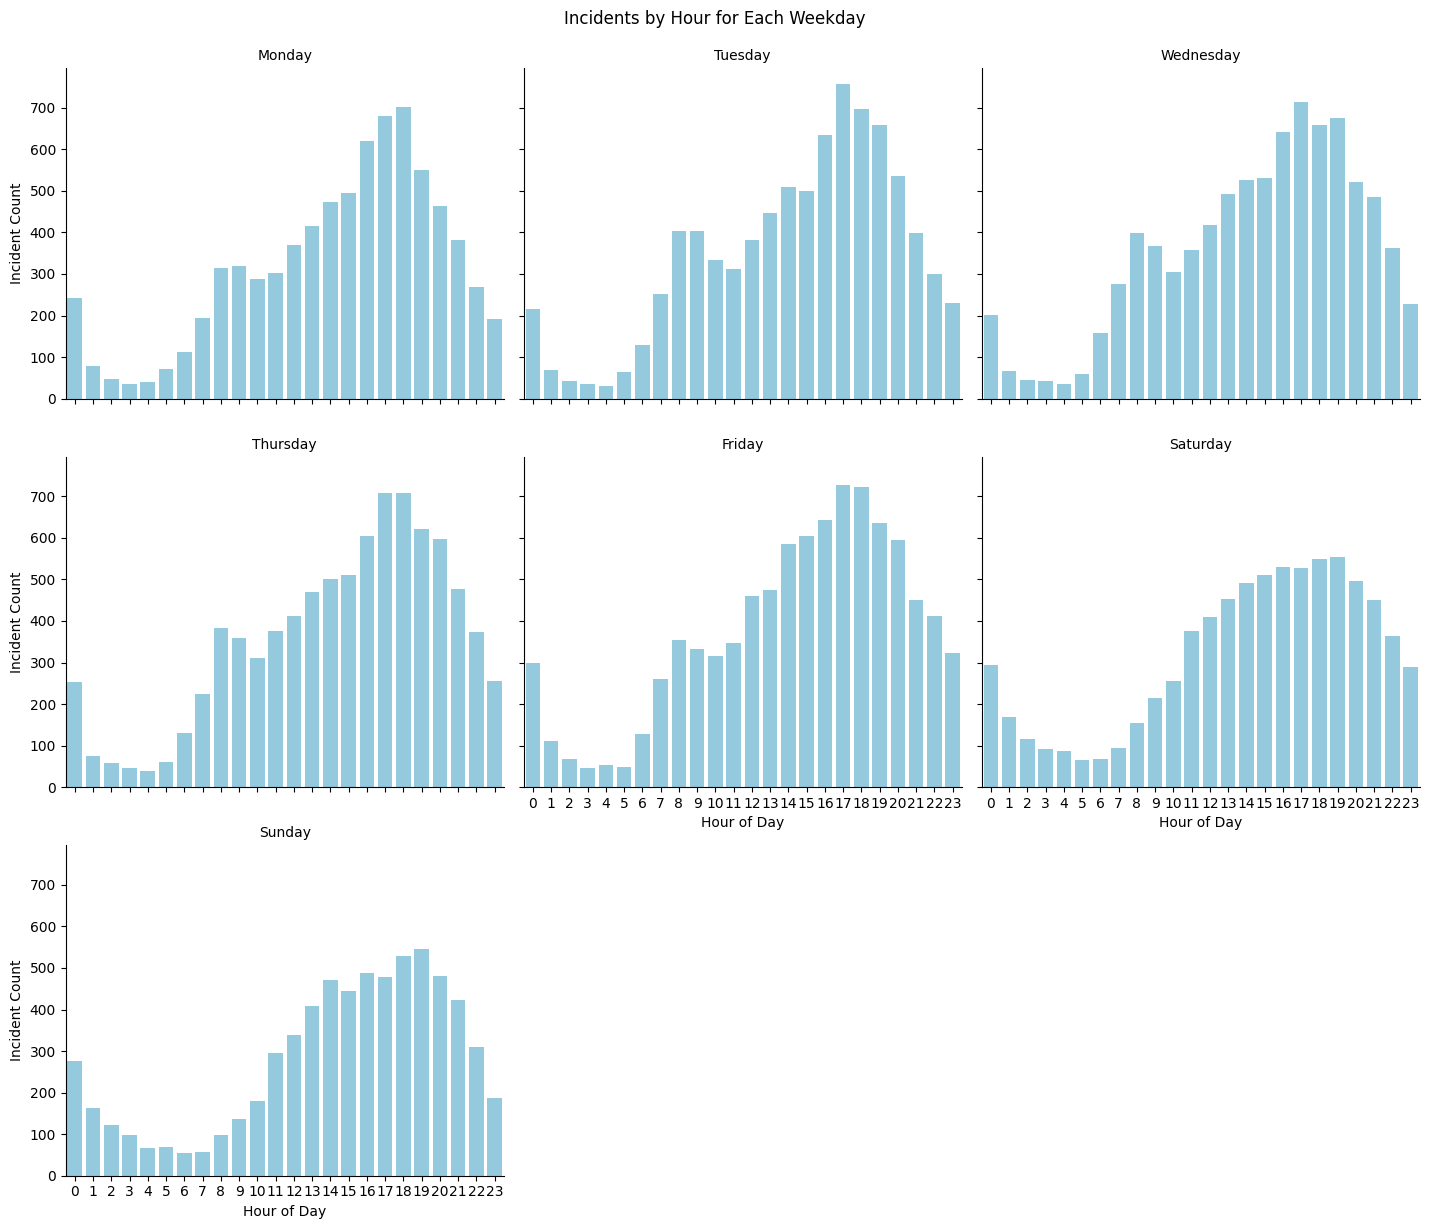

In [17]:
# define the order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# generate a facetgrid
g = sns.FacetGrid(incident_by_time, col="crash weekday", col_order=weekday_order, height=4, col_wrap=3, aspect=1.2, sharey=True)

# plot the incident count by hour
hour_order = sorted(incident_by_time['crash hour'].unique())
g.map(sns.barplot, "crash hour", "incident_count", color="skyblue", order=hour_order)

# Add a title and labels
g.set_axis_labels("Hour of Day", "Incident Count")
g.set_titles("{col_name}")
g.fig.suptitle("Incidents by Hour for Each Weekday", y=1.02)
plt.show()

#### Summarize the incidence over all days

Incidents by Hour:



Text(0.5, 1.0, 'Incidents by hour')

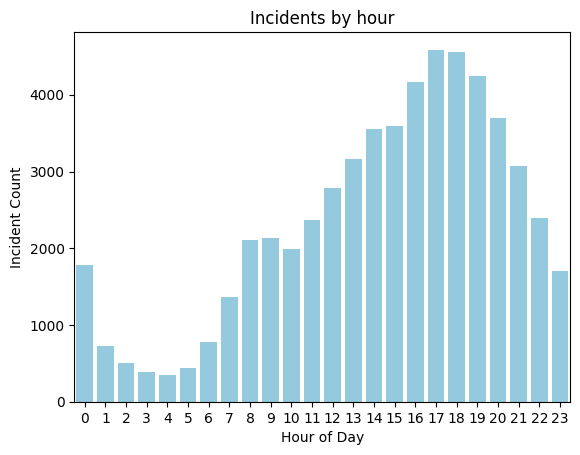

In [18]:
incident_by_hour = nypd_near_citibike.groupby(['crash hour']).size().reset_index(name='incident_count')
incident_by_weekday = nypd_near_citibike.groupby(['crash weekday']).size().reset_index(name='incident_count')

# Display high-risk times
print("Incidents by Hour:\n")
incident_bar = sns.barplot(incident_by_hour, x="crash hour", y="incident_count", color="skyblue", order=hour_order)
incident_bar.set_xlabel("Hour of Day") 
incident_bar.set_ylabel("Incident Count")
incident_bar.set_title("Incidents by hour")



- Unfälle treten gehäuft am Nachmittag/frühen Abend auf
- tendentiell weniger am Wochenende
- Anpassung der Tarife


### What are contributing human factors?

In [19]:
# What are the most common human factors for accidence 
incident_by_factor = nypd_near_citibike.groupby(['Contributing Factors']).size().reset_index(name='incident_count')
print("\nHigh-Risk Behaviour:\n", incident_by_factor.nlargest(20, "incident_count"))
print(incident_by_factor.sum())



High-Risk Behaviour:
                                   Contributing Factors  incident_count
106                                        Unspecified           37363
10                      Driver Inattention/Distraction            6831
71   Pedestrian/Bicyclist/Other Pedestrian Error/Co...            2268
22                       Failure to Yield Right-of-Way            1731
60                      Passing or Lane Usage Improper            1037
85                         Traffic Control Disregarded             966
49                                     Other Vehicular             956
57                               Passenger Distraction             688
30                               Following Too Closely             646
99                                        Unsafe Speed             548
59                                 Passing Too Closely             465
14                                 Driver Inexperience             339
91                                  Turning Improperly

- Risikofaktoren kann man z.T. monitoren per App (z.B. speed)
- Infrastrukturverbesserungen
- Erhöhen der Sichtbarkeit in bestimmten gebieten

## Risk modeling

### Feature engineering

In [20]:
# feature engine
incident_by_station_day_hour = nypd_near_citibike.groupby(["station_id", "crash weekday", "crash hour"]).size().reset_index(name='incident_count')
display(incident_by_station_day_hour.head())

,station_id,crash weekday,crash hour,incident_count
0,2733.03,Friday,0,3
1,2733.03,Friday,1,1
2,2733.03,Friday,2,1
3,2733.03,Friday,4,1
4,2733.03,Friday,5,1


#### Generate a feature set

In [21]:
# merge the accident data with the Citibike stations to create a feature set
bike_merged = pd.merge(bike_data, incident_by_station_day_hour, 
                       left_on=['start_station_id', 'start_hour', 'start_weekday'],  # columns from citibike_data
                       right_on=['station_id', 'crash hour', 'crash weekday'],  # columns from incident_counts
                       how='left')

# set the accident counts for the start station
bike_merged["start_incident_count"] = bike_merged["incident_count"].values

# drop unwanted columns
bike_merged = bike_merged.drop(columns=incident_by_station_day_hour.columns)

# merge the accidents for end stations as well
bike_merged = pd.merge(bike_merged, incident_by_station_day_hour, 
                       left_on=['end_station_id', 'end_hour', 'end_weekday'],  # columns from citibike_data
                       right_on=['station_id', 'crash hour', 'crash weekday'],  # columns from incident_counts
                       how='left')

# set the accident counts for the end station
bike_merged["end_incident_count"] = bike_merged["incident_count"].values

# drop unwanted columns
bike_merged = bike_merged.drop(columns=incident_by_station_day_hour.columns)

# fill missing values and convert to integer
for col in ["start_incident_count", "end_incident_count"]:
    bike_merged[col] = bike_merged[col].fillna(0)
    bike_merged[col] = bike_merged[col].astype(int)

# get the total accident count associated with the single trips
bike_merged["total_incident_count"] = bike_merged["end_incident_count"] + bike_merged["start_incident_count"]

# add a target value for accident prediction
bike_merged["target"] = (bike_merged["total_incident_count"] > 0).astype(int)

display(bike_merged.head())
print(bike_data.shape)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_year,start_month,start_day,start_hour,end_year,end_month,end_day,end_hour,start_weekday,end_weekday,start_incident_count,end_incident_count,total_incident_count,target
0,D86F678648E7A867,electric_bike,2024-09-10 22:50:16.212,2024-09-10 23:30:44.697,Hudson St & W 13 St,6115.06,Broadway & W 58 St,6948.10,40.740057,-74.005274,40.766953,-73.981693,casual,2024,9,10,22,2024,9,10,23,Tuesday,Tuesday,1,0,1,1
1,032D1788CD512084,electric_bike,2024-09-22 05:51:00.609,2024-09-22 05:56:50.446,W 37 St & 5 Ave,6398.06,9 Ave & W 45 St,6717.06,40.750380,-73.983390,40.760193,-73.991255,member,2024,9,22,5,2024,9,22,5,Sunday,Sunday,1,0,1,1
2,DA55381E5121F0F9,electric_bike,2024-09-24 11:07:40.618,2024-09-24 11:29:23.460,Greenpoint Ave & West St,5752.09,2 Ave & E 72 St,6925.09,40.729803,-73.959099,40.768762,-73.958408,member,2024,9,24,11,2024,9,24,11,Tuesday,Tuesday,0,0,0,0
3,F67A042C028C6367,classic_bike,2024-09-03 14:25:28.732,2024-09-03 14:33:51.075,E 85 St & 3 Ave,7212.05,2 Ave & E 72 St,6925.09,40.778012,-73.954071,40.768762,-73.958408,member,2024,9,3,14,2024,9,3,14,Tuesday,Tuesday,0,0,0,0
4,31F722D5EAB9C780,electric_bike,2024-09-09 15:46:50.376,2024-09-09 15:50:16.411,7 Ave & Park Pl,4125.07,Carroll St & 6 Ave,4019.06,40.677615,-73.973243,40.674089,-73.978728,member,2024,9,9,15,2024,9,9,15,Monday,Monday,0,0,0,0


(999338, 23)


In [22]:
# Define features and target
features = ['start_station_id', 'start_hour', 'start_weekday', 'start_lat', 'start_lng', 
            'end_station_id', 'end_hour', 'end_weekday', 'end_lat', 'end_lng']

# get a feature matrix
X = bike_merged[features]

# get a target vector
y = bike_merged['target']

#### Splitting the data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Define a pipeline and model and transform categorical features

In [24]:
# since we have categorical and ordinal features, we need transformers
hour_order = list(range(24))  # 0 to 23 for hours
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# define preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=[hour_order, weekday_order, hour_order, weekday_order]), ['start_hour', 'start_weekday', 'end_hour', 'end_weekday']),  # ordinal
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['start_station_id', 'end_station_id']),  # categorical
        ('num', 'passthrough', ['start_lat', 'start_lng', 'end_lat', 'end_lng'])  # numerical
    ]
)

# combine preprocessor with the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=24, max_iter=300)), 
])

# fit and train the model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81    135863
           1       0.58      0.23      0.32     64005

    accuracy                           0.70    199868
   macro avg       0.65      0.57      0.57    199868
weighted avg       0.67      0.70      0.65    199868



## Mit mehr Zeit/Daten:

- Optimieren des Risikomodels, andere Verfahren
- Feature Optimierung
- Verwendung der kompletten Daten von Citibike
- Optimieren der Performance für große Datenmengen
- Implementierung des Datenretrieval (update, neue Daten)

## Mehr Daten?

- Routen und GPS tracking
- Anonymisierte Nutzerdaten, Nutzerprofile, Risikoverhalten
- Tatsächliche Unfalldaten von Nutzern